# Topographic Influences on Snowmelt in a Warming World

### With Airborne Snow Observatory (ASO) Lidar Data
#snowmelt

## Project Introduction

### The Tuolumne River Basin (TRB) is a major water supply for California
- Winter snowpack in the TRB is a natural form of water storage
- Expecting warming temperatures, like those seen in 2015, are going to continue
- Interested to see how warming temperatures will affect that water resource

In [1]:
import folium
from IPython.display import Image

MAP_CENTER = [37.818056, -119.217238] # TRB
m = folium.Map(location=MAP_CENTER, tiles='Stamen Terrain', zoom_start=7) 
folium.Marker(MAP_CENTER, popup='Tuolume River Basin, CA').add_to(m); m

### The Data
- ASO Lidar can provide snapshots of snowdepth across a watershed
- Snow depth (30m, ASO lidar-derived) for 2014 & 2015
- DEM (30m, ASO lidar-derived) for the TRB

Link to the data: https://drive.google.com/drive/folders/1uhxMHkf9YgU2qVDntqTGSbzZlJY0v94X

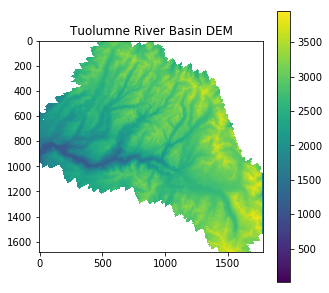

In [1]:
import rasterio
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

with rasterio.open('./ghw2018_snowmelt_data/dem30m.tif') as raster:
    dem = raster.read(1)
    
plt.figure(figsize=(5,5))
plt.imshow(dem)
plt.title("Tuolumne River Basin DEM"); plt.colorbar();

## Specific Questions and Goals

### Science Questions
- How does snow depth change during the melt season as a function of **topography** (slope, aspect, elevation) in the Tuolumne River watershed?
- How does snow depth vary between two melt seasons as a function of change in temperature?
- How do these behaviors compare between a “normal” snowpack years (2014, 2016) and a warmer year (2015)?

### Group Goals
#### Hands-on experience using Geohackweek tutorial tooks to analyize this data
- Jupyter Notebook
- Raster Manupulation 
- Python Statistics 


In [6]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import pprint
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')

# load the mask
with rasterio.open("./ghw2018_snowmelt_data/scene_30m_mask.tif") as raster:
    mask = raster.read(1)

## Load All Data Into a Dict of Arrays Representing Rasters

In [3]:
from os import walk
import re

data_files = []
for (dirpath, dirnames, filenames) in walk('./ghw2018_snowmelt_data'):
    for f in filenames:
        if 'SUPERsnow' in f:
            data_files.append(f)

data = {
    '2014': [],
    '2015': [],
    '2016': []
}

dates = { '2014': [], '2015': [], '2016': [] }

for file in data_files:
    match = re.match("\w{2}(\d{4})(\d{4}).*", file)
    if match:
        if match.group(1) in data.keys():
            with rasterio.open(f'./ghw2018_snowmelt_data/{file}') as raster:
                data[match.group(1)].append(raster.read(1)*mask)
                dates[match.group(1)].append(parser.parse(match.group(1) + match.group(2)))

## Use Xarray to Generate Timepoint-by-timepoint Plots for All Data

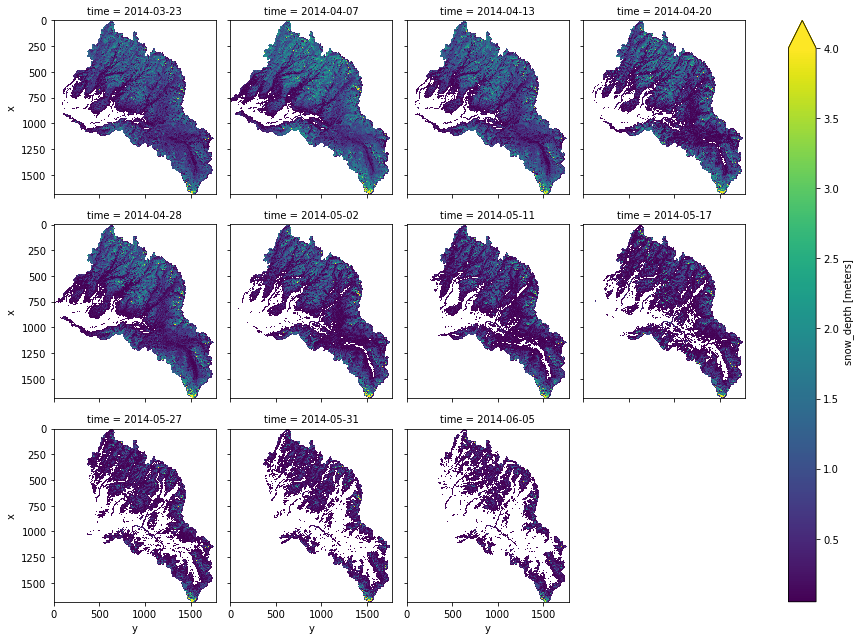

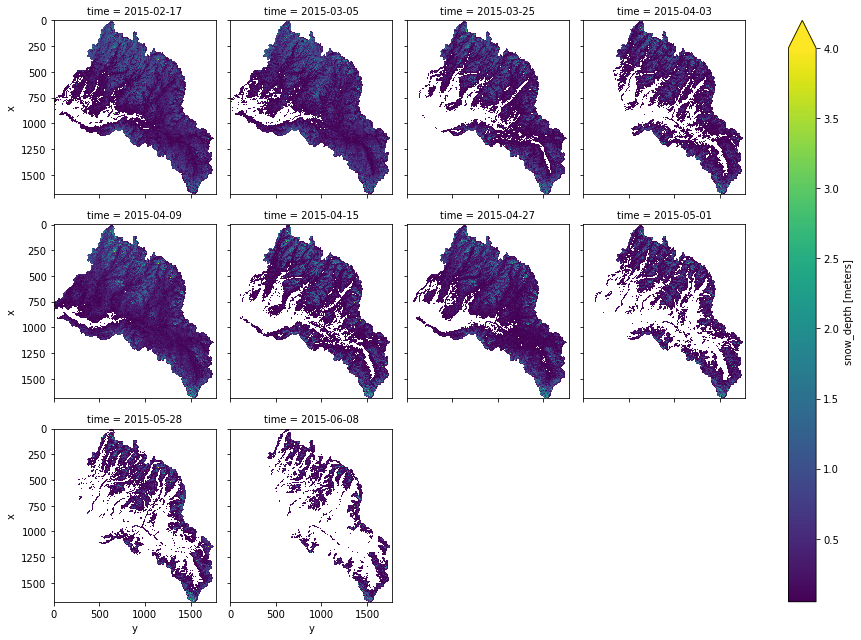

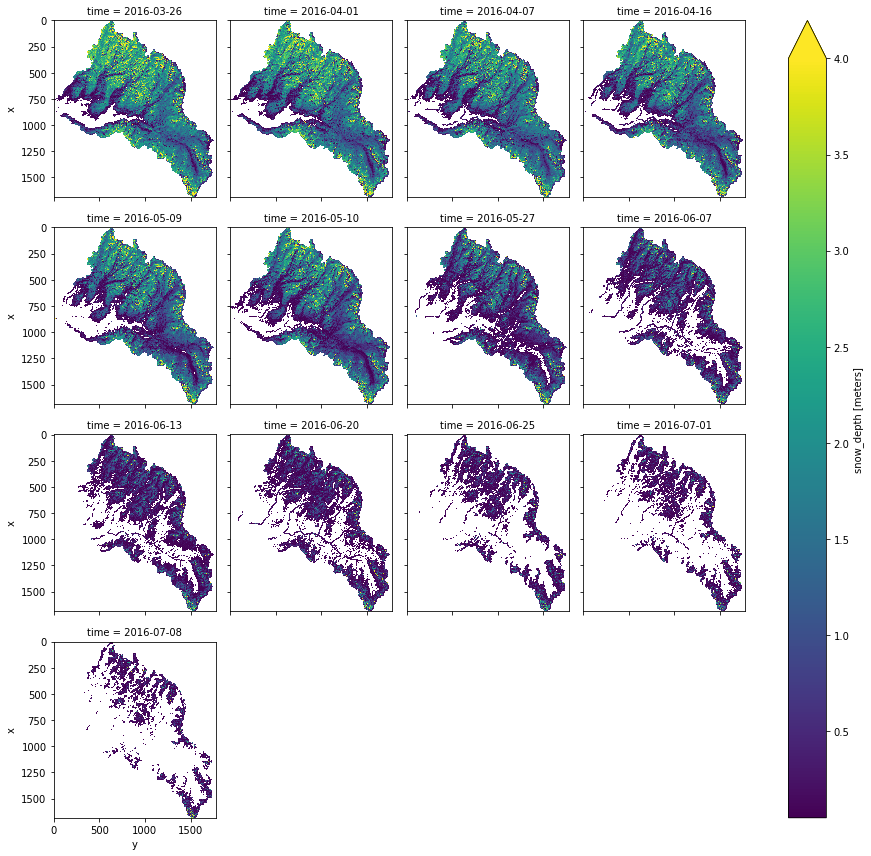

In [7]:
for year,values in data.items():
    data_matrices = np.asarray(values)
    data_array = xr.DataArray(data_matrices,
                    dims=('time','x', 'y'),
                    coords={'x': range(1684), 'y': range(1777),'time': dates[year]},
                    attrs={'units': 'meters'},
                    name='snow_depth')
    data_array.sortby('time').plot(col='time', col_wrap=4, vmax=4)
    plt.gca().invert_yaxis()

## Visualizing Mean Rate of Snowmelt Across the Watershed Overlayed on Aspect

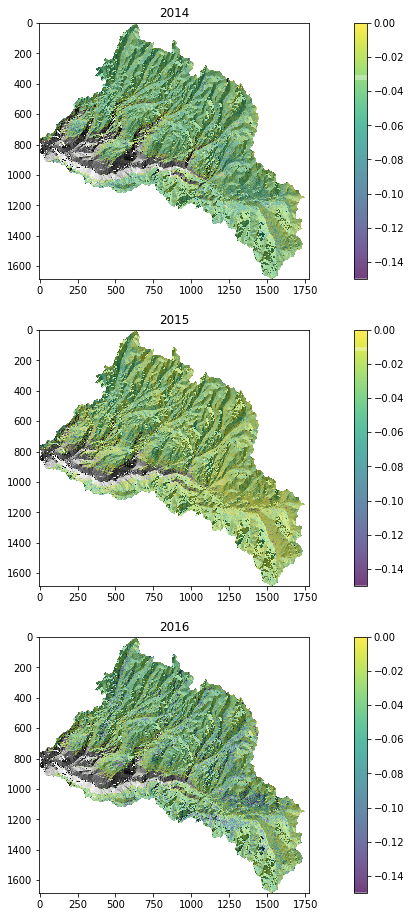

In [8]:
with rasterio.open('./ghw2018_snowmelt_data/aspect30m.tif') as raster:
    aspect = raster.read(1)*mask

plt.figure(figsize=(16,16))
plot_number = 1

for year,values in data.items():
    data_matrices = np.asarray(values)
    data_matrices = np.nan_to_num(data_matrices)
    diffs = np.diff(data_matrices, axis=0)
    # make sure all near-0s are nans and all positive values are nans for calculating snowmelt rate
    modified_diffs = np.copy(diffs)
    modified_diffs[abs(modified_diffs) < 0.001] = np.nan
    modified_diffs[modified_diffs > 0] = np.nan
    
    diffdays = []
    curr_dates = dates[year]

    for i in range(len(curr_dates)):
        if i < len(curr_dates) - 1:
            d1 = parser.parse(f"{curr_dates[i+1]}")
            d2 = parser.parse(f"{curr_dates[i]}")
            diffdays.append((d1 - d2).days)

    for i in range(len(modified_diffs)):
        modified_diffs[i] = modified_diffs[i] / diffdays[i]

    mean_snowmelt_rate = np.nanmean(modified_diffs, axis=0)
    plt.subplot(3,1, plot_number)
    plt.imshow(aspect, cmap='Greys')
    plt.imshow(mean_snowmelt_rate, vmin=-0.15, vmax=0, alpha=0.5)
    plt.title(year)
    plt.colorbar()
    plot_number += 1

### Exploring elevation data

- Create histogram of elevation distribution

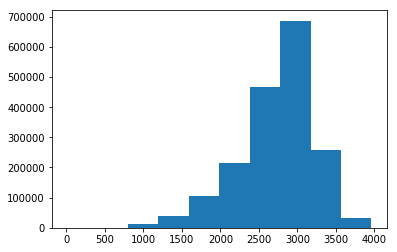

In [7]:
import numpy as np
heights = dem[~np.isnan(dem)];
heights = heights.ravel();
plt.hist(heights);

- Divided the DEM into elevation bands
- Bands from 600m to 4100m

## Elevation Bands
#### Why? It is easier to analyze the relationship between snow depth and elevation with elevation represented in bins, as opposed to continuous data.

### The plots below show the difference in snow depth between February and March 2014 at each elevation band



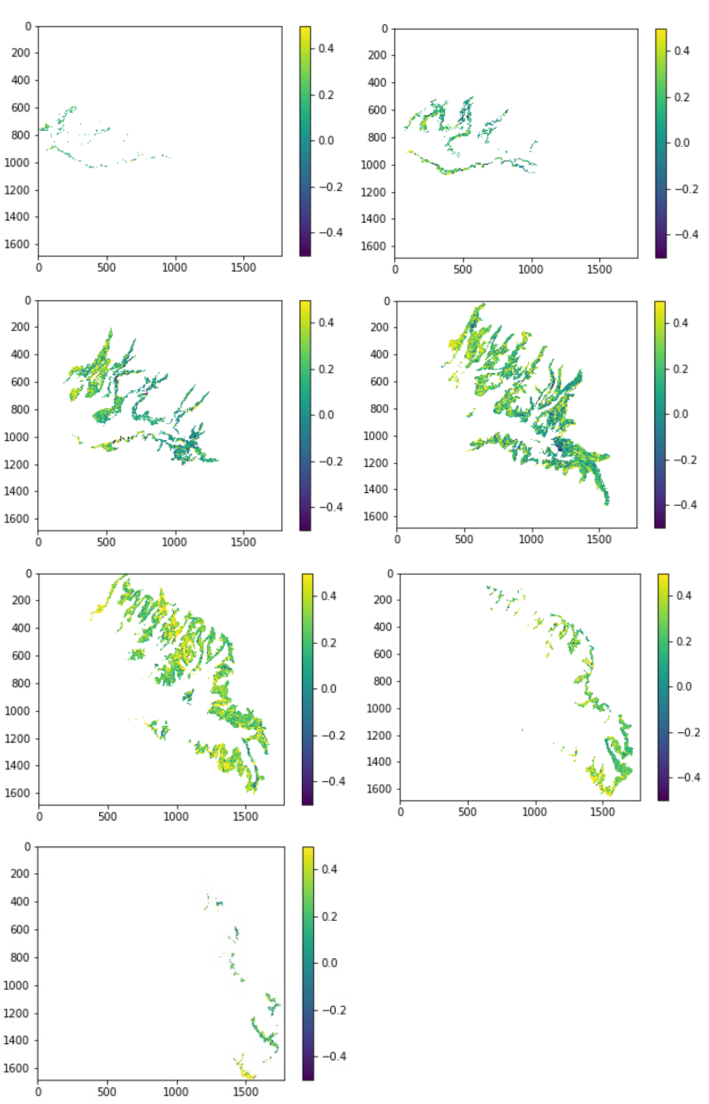

In [8]:
fig = Image(filename=('./plots/bandplots.PNG')); fig

### Seaborn Histograms
Histogram of change in snow depth during different image capture dates in 2015. Y-axis is frequency (in hundred thousands). We can see snow melt increasing as the season progresses, as expected.

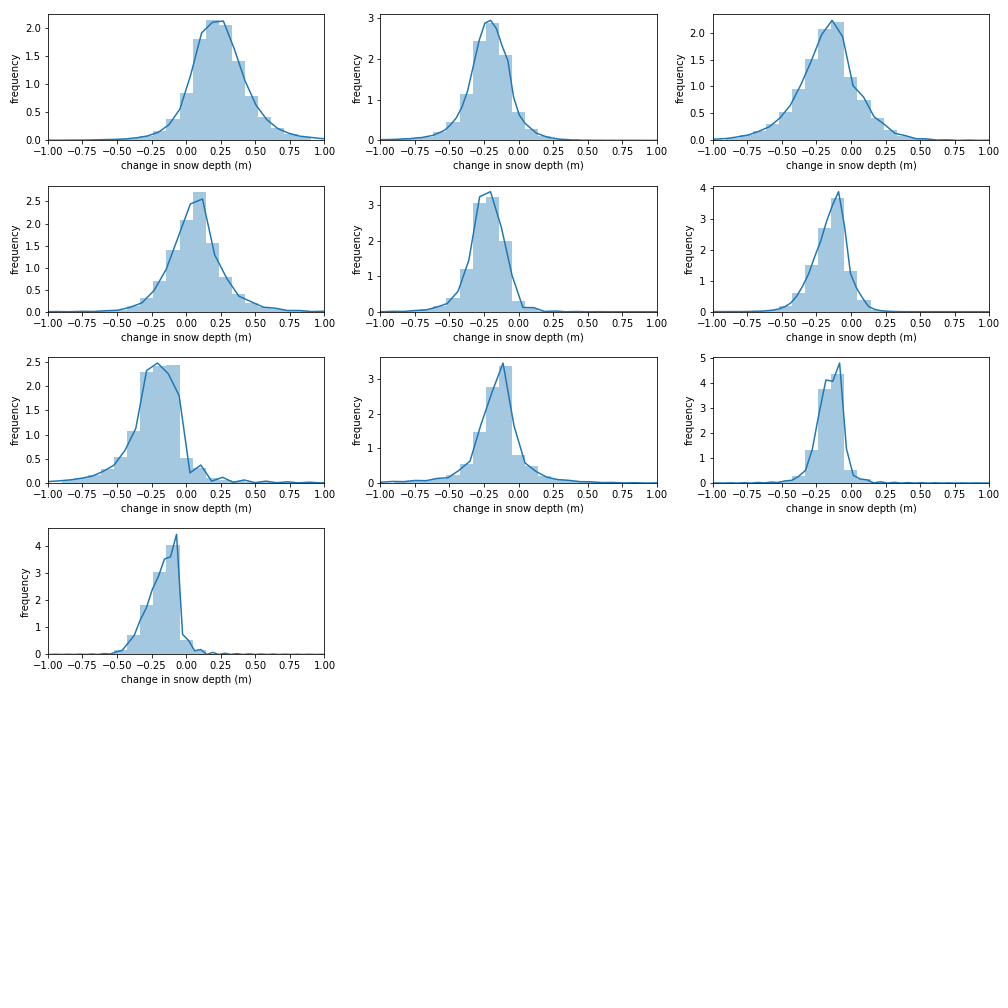

In [9]:
fig = Image(filename=('./plots/distplotofdiffs.png')); fig

### Climate Data and Analysis:

#### 1. Downloaded PRISM monthly observational data (2014-2016 period) for the following variable:
- Precipitation
- Mean Temperature
- Minimum Temperature
- Maximum Temperature

#### 2. Reprojected and Clipped the data to Tuolumne Watershed.
#### 3. Analyzed  and calculated differences between years with 2015 as reference years.


**Tools Used:**
xarray
numpy array
gdal
rasterio
matplotlib


**Result**

The year 2015 was warmer and drier as compared to 2014 as well as 2016.

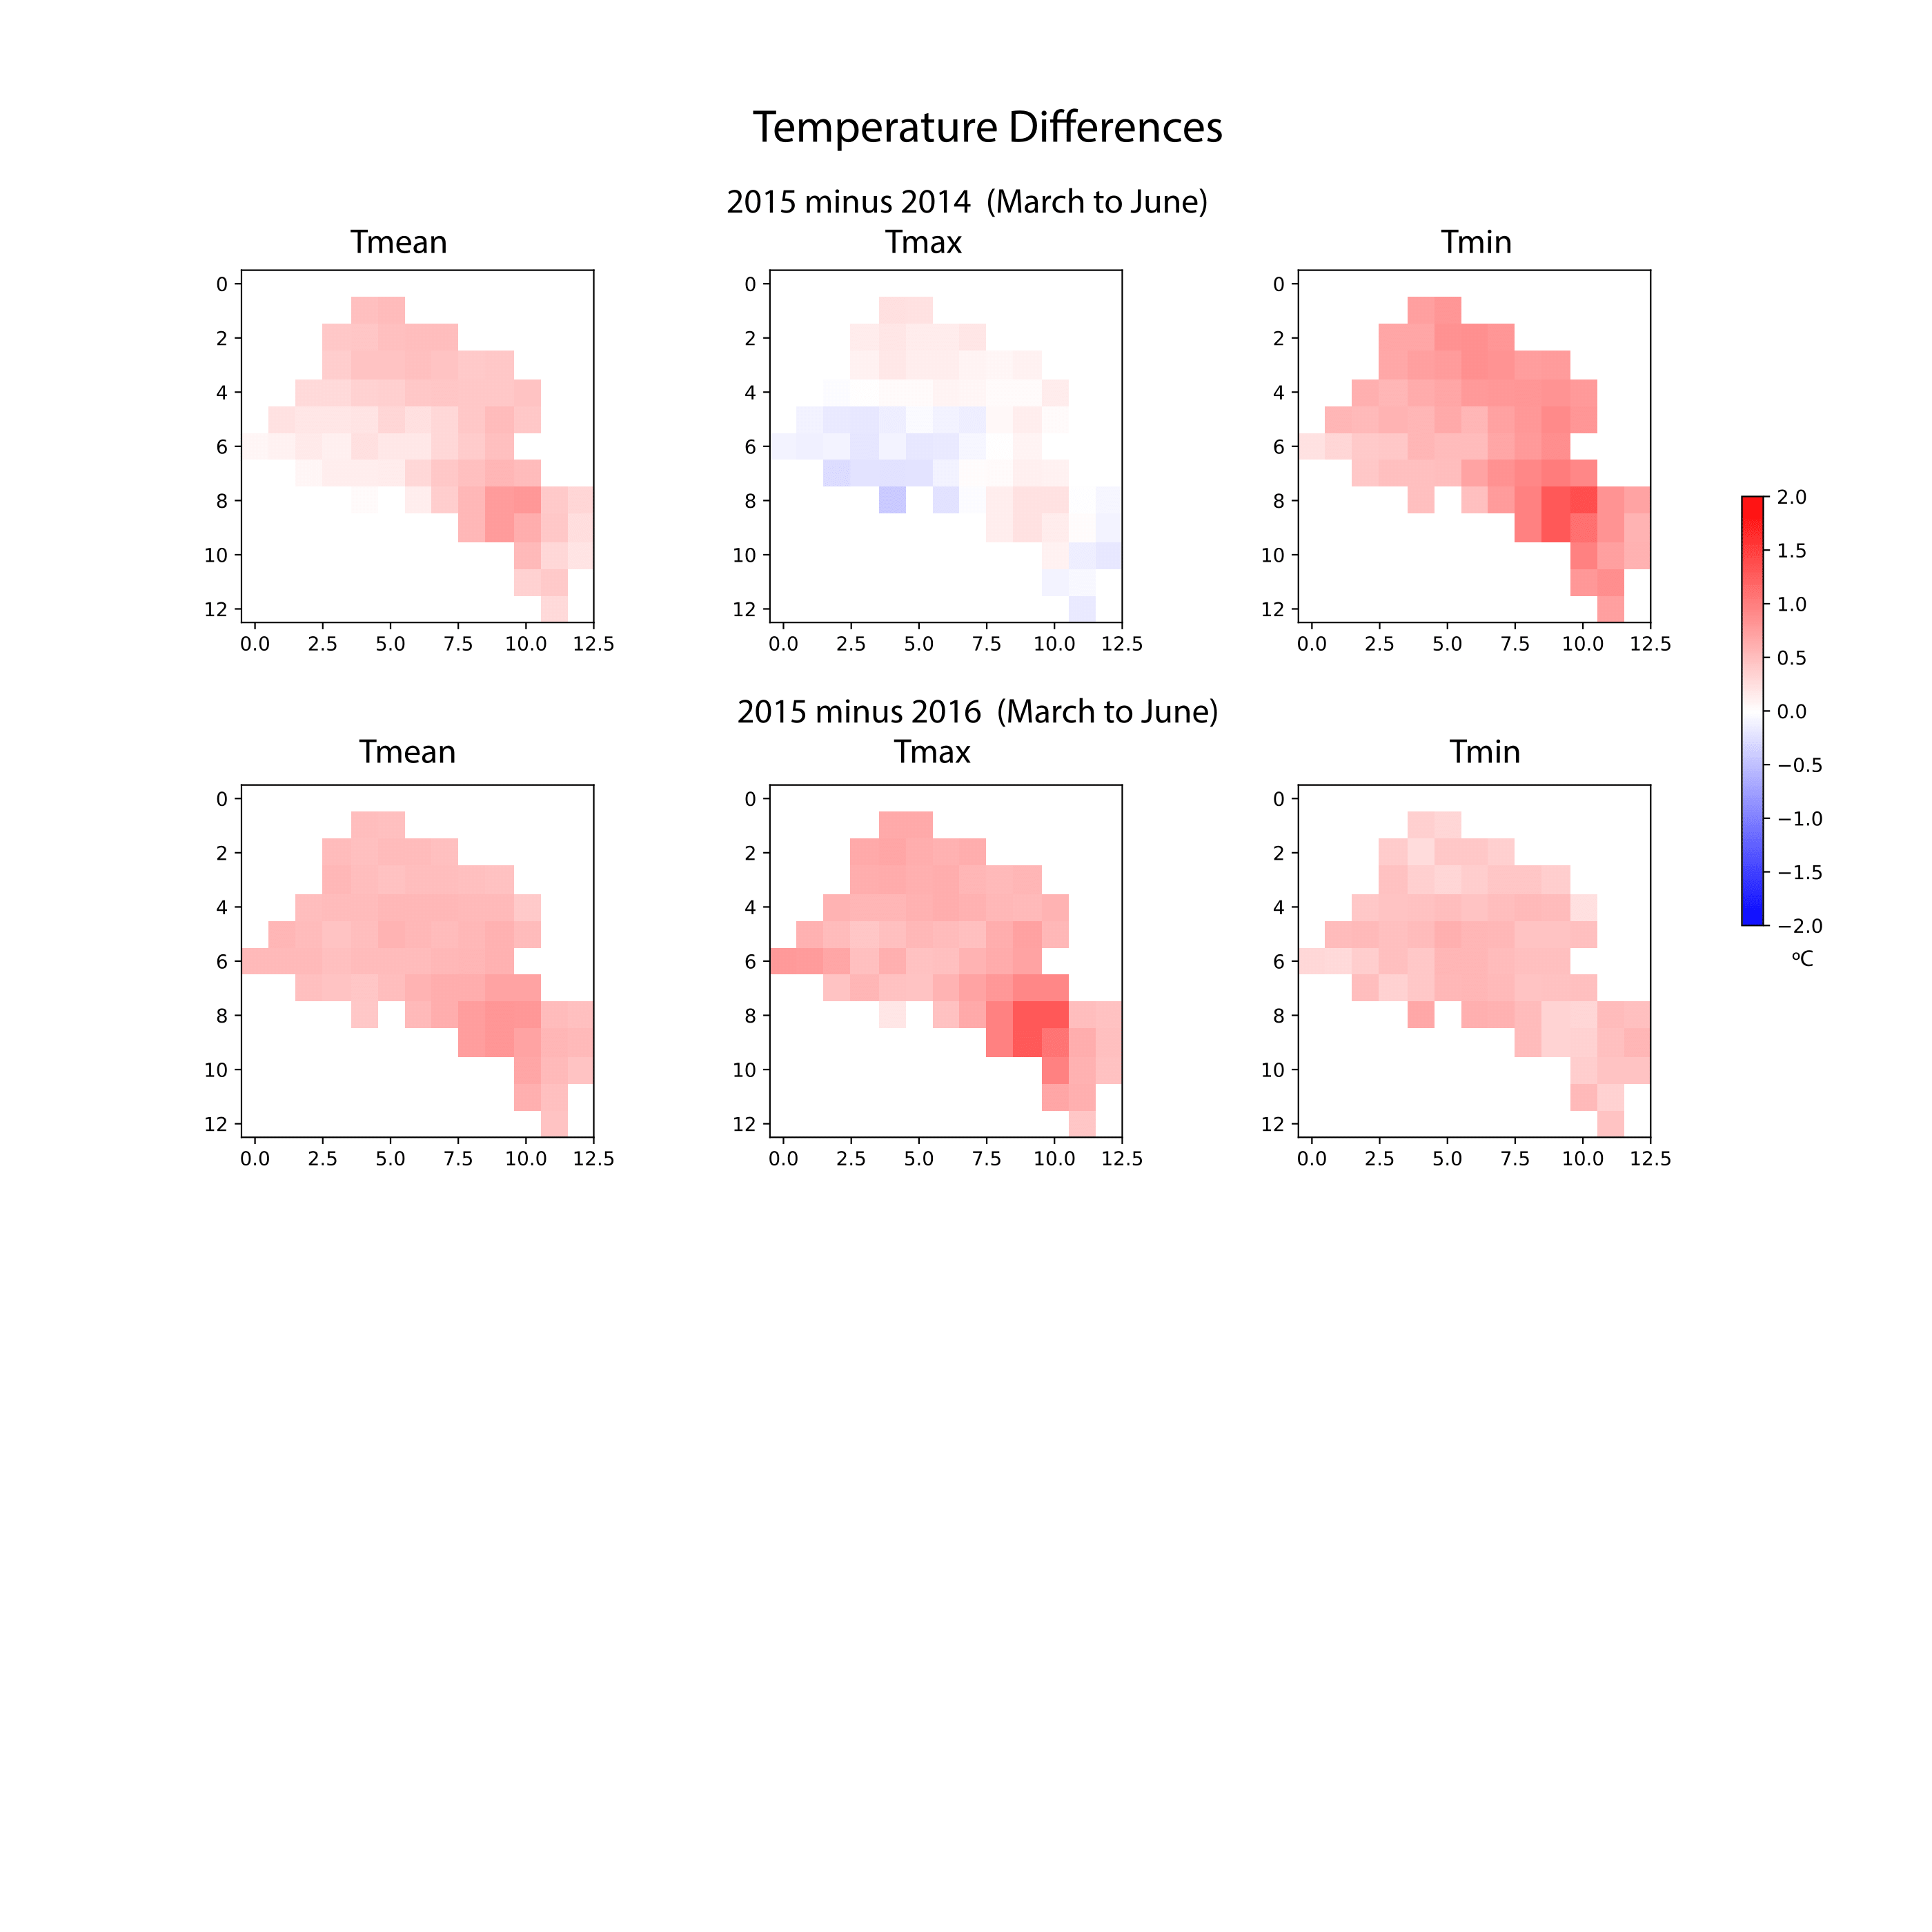

In [10]:
fig = Image(filename=('./plots/temperature.png')); fig

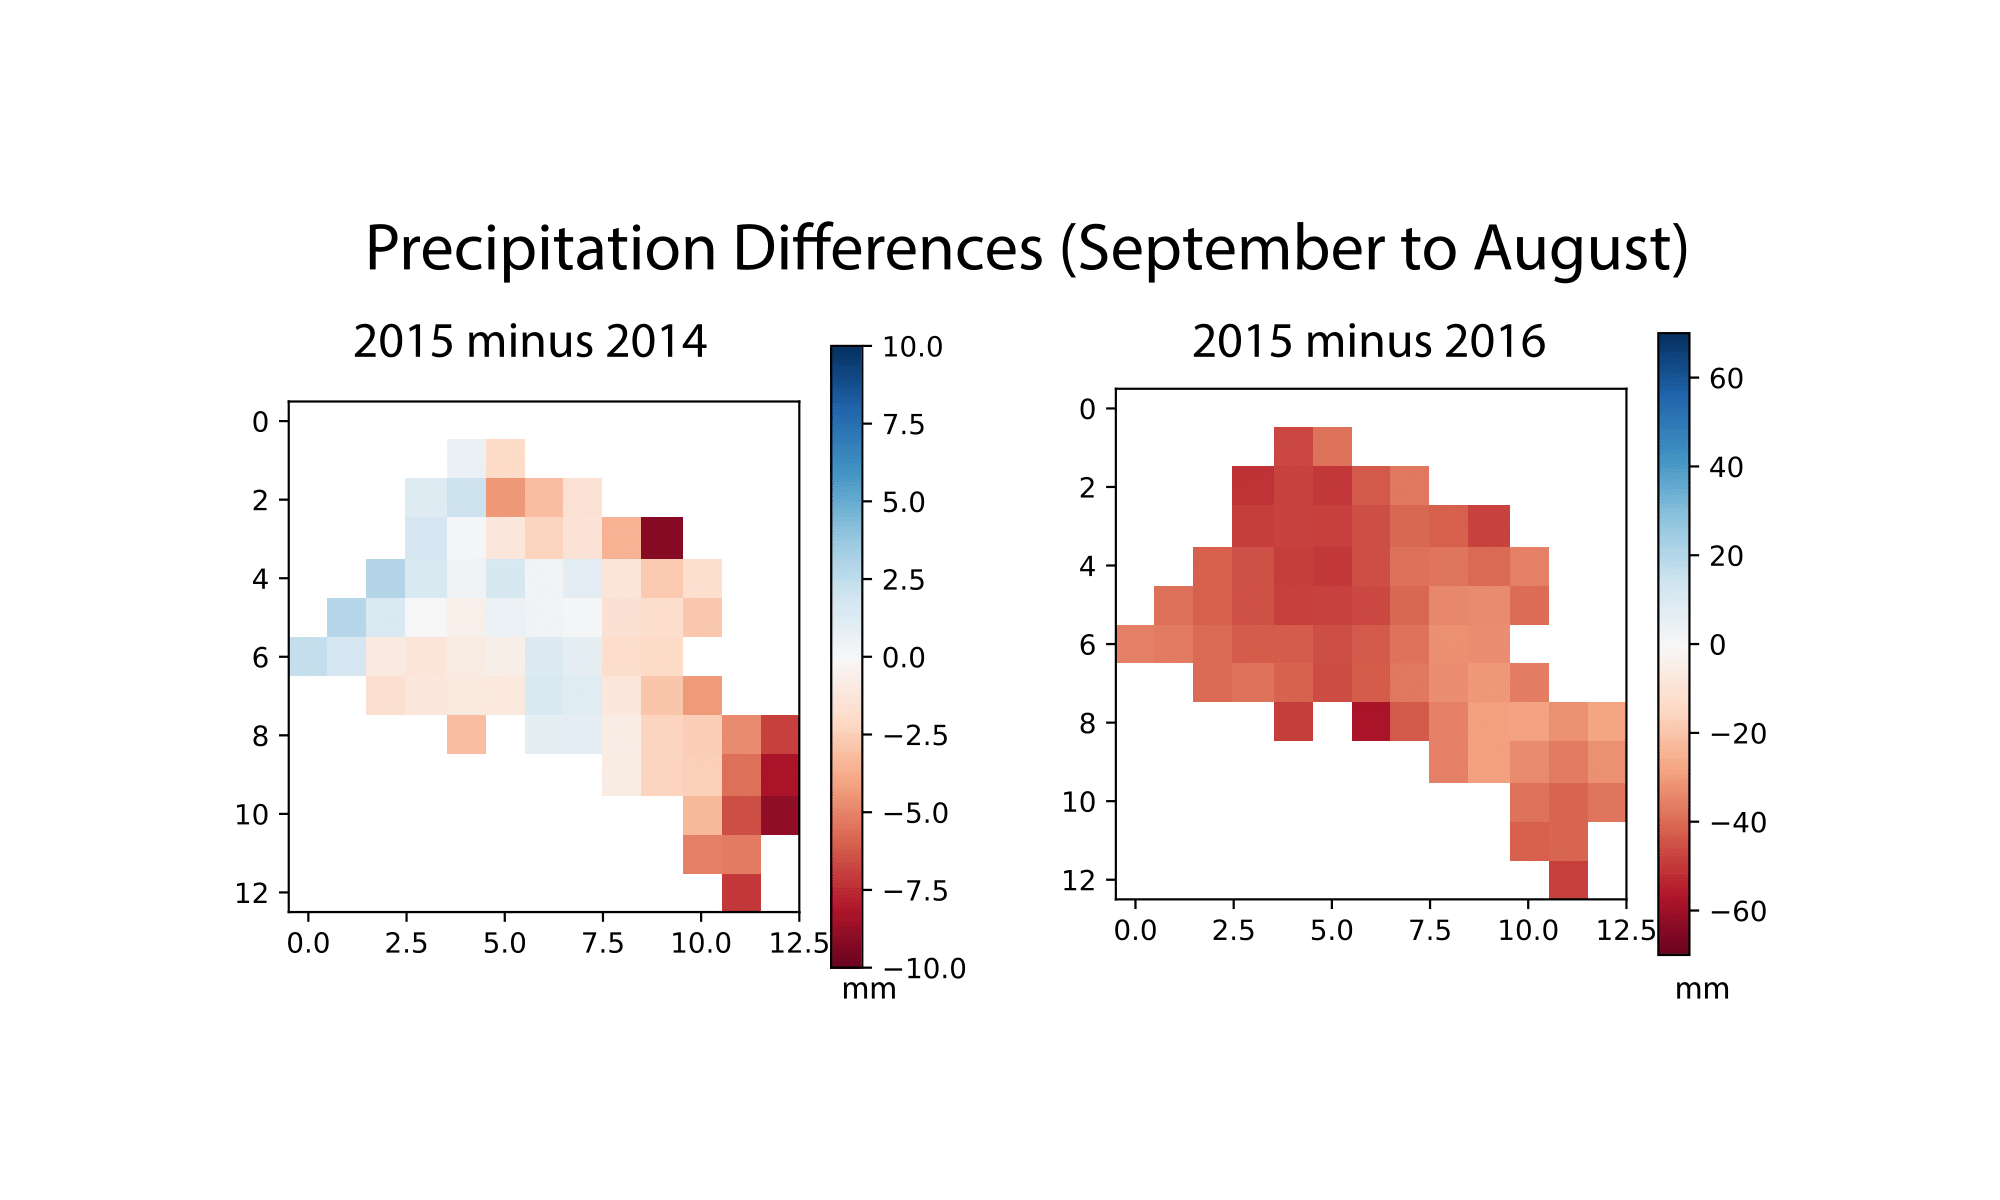

In [11]:
fig = Image(filename=('./plots/precipitation.png')); fig

#### Plots of basin-wide mean snowdepth (m), and mean change in snowdepth (delta m) for each year 2014, 2015, 2016.

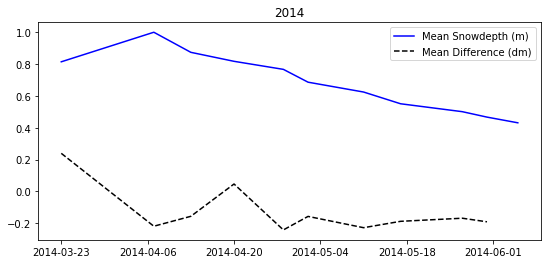

In [12]:
fig = Image(filename=('./plots/2014_monthly_mean_snowdepth_and_difference.png')); fig

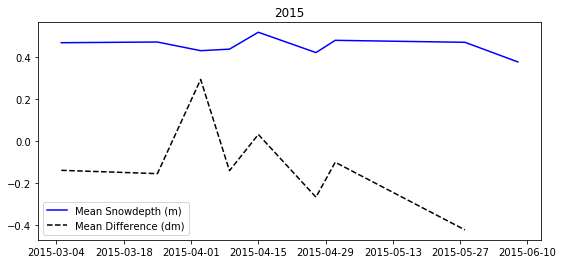

In [13]:
fig = Image(filename=('./plots/2015 monthly mean snowdepth and difference.png')); fig